# Out of Distribution Data for "ML the vanishing order of rational L-functions" #

At Harvard's CMSA [recent workshop on Math and ML](https://cmsa.fas.harvard.edu/event/mml_2025/), Alyson Deines and Tamara Deenstra gave a talk that included some of our recent work. (See [arxiv link to ML the vanishing order](https://arxiv.org/pdf/2502.10360) and the reference [BBCDLLDOQV25b](https://davidlowryduda.com/research/#BBCDLLDOQV25b) on my research page.)

To summarize one observation in few words: an $L$-function can be written as

$$ L(s) = \sum_{n \geq 1} \frac{a(n)}{n^s} $$

and satisfies a functional equation of the shape $\Lambda(s) := N^{s} G(s) L(s) = \varepsilon \Lambda(1 - s)$, where $N$ and $\varepsilon$ are distinguished numbers called the conductor and root number, respectively, and where $G(s)$ is a product of gamma factors. We're interested in rational $L$-functions, where the coefficients $a(n)$ are rational numbers when appropriately normalized. These arise from counting questions in number theory and arithmetic geometry.

Conjecturally, the analytic behavior of $L(s)$ at $s = 1/2$ contains deep arithmetic information about the associated counting questions. One such conjecture is the [Birch and Swinnerton-Dyer Millenium Conjecture](https://en.wikipedia.org/wiki/Birch_and_Swinnerton-Dyer_conjecture), which says that the order of vanishing at $s = 1/2$ of the $L$-function associated to an elliptic curve agrees with the arithmetic rank of the curve.

No one knows how to prove those results. In [BBCDLLDOQV25b](https://davidlowryduda.com/research/#BBCDLLDOQV25b), we looked to see if ML might successfully learn something about the order of vanishing from the first several coefficients.

Aside: model success or failure wouldn't say something conclusive about BSD or related conjectures. But in practice, ML can act like a one-sided oracle: if model performance on a particular set of features is very high, this indicates that the arithmetic information is contained within those set of features. If mathematicians don't understand *why* or *how*, then at least this can point to a place where we can look for more.

One suggestive graph comes from looking at the 2D PCA. Let's make it here. The data is available at https://zenodo.org/records/14774042. In the code below, this data is in the file `lfun_rat_withap.txt`.

In [1]:
import pandas as pd
import numpy as np

In [2]:
def is_prime(n):
    "Naive prime detection"
    if n < 2:
        return False
    if n < 4:
        return True
    for d in range(2, int(n**.5) + 2):
        if n % d == 0:
            return False
    return True


assert [p for p in range(20) if is_prime(p)] == [2, 3, 5, 7, 11, 13, 17, 19]


def write_to_float(ap_list):
    """
    Convert the ap string containing aps to a list of ints.
    """
    ap_list = ap_list.replace('[','')
    ap_list = ap_list.replace(']','')
    ap_list = [float(ap) for ap in ap_list.split(',')]
    return ap_list


ALL_COLUMNS = [str(n) for n in range(1,1001)]
PRIME_COLUMNS=[str(p) for p in range(1000) if is_prime(p)]


def write_to_murm_normalized_primes(an_list, w, d = 1):
    """
    Convert the ap strings to a list of normalized floats.
    """
    an_list = an_list.strip('[')
    an_list = an_list.strip(']')
    an_list = [int(an) for an in an_list.split(',')]
    normalized_list = []
    for n, an in enumerate(an_list):
        p=int(PRIME_COLUMNS[n])
        normalization_quotient = d * (p**(w/2.))
        normalized_list.append(np.float32(round(an / normalization_quotient, 5)))
    return normalized_list


def build_murm_ap_df(DF):
    """
    Create a dataframe expanding the single column list of Dirichlet coefficients
    into only prime coefficients, with a single column per prime.
    """
    # Copy all the existing columns except 'ap'
    base = DF.drop(columns=["ap"]).copy()
    
    # Expand prime coefficients for each row
    prime_expanded = pd.DataFrame(
        [write_to_murm_normalized_primes(a, w, d) 
         for w, a, d in zip(DF["motivic_weight"], DF["ap"], DF["degree"])],
        columns=PRIME_COLUMNS,
        index=DF.index
    )
    DF_new = pd.concat([base, prime_expanded], axis=1)
    return DF_new

In the code above, the coefficients are normalized. Coefficient normalization in $L$-functions is an easy source of confusion. Different applicatoins and contexts suggest different obvious normalizations. Instead of detailing this normalization, I'll note that the effect is that the functional equations in this normalization have shape $s \mapsto 1 - s$, and the normalized coefficients vary between $[-1, 1]$.

In [3]:
fname = "lfun_rat_withap.txt"
DF_base = pd.read_table(fname, delimiter=":")

In [4]:
DF_base.head()

label  primitive conductor  central_character  motivic_weight  \
0     1-1-1.1-r0-0-0       True         1               1.10               0   
1     1-5-5.4-r0-0-0       True         5               5.40               0   
2   1-2e3-8.5-r0-0-0       True         8               8.50               0   
3  1-12-12.11-r0-0-0       True        12              12.11               0   
4  1-13-13.12-r0-0-0       True        13              13.12               0   

   degree  order_of_vanishing         z1  root_angle  root_analytic_conductor  \
0       1                   0  14.134725         0.0                 0.004644   
1       1                   0   6.648453         0.0                 0.023220   
2       1                   0   4.899974         0.0                 0.037152   
3       1                   0   3.804628         0.0                 0.055728   
4       1                   0   3.119341         0.0                 0.060372   

                    instance_types  \
0  ['NF', 'DIR', 'Artin', 'Artin']   
1                          ['DIR']   
2                          ['DIR']   
3                          ['DIR']   
4                          ['DIR']   

                                                  ap  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [-1, -1, 0, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1,...  
2  [0, -1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1,...  
3  [0, 0, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, -1,...  
4  [-1, 1, -1, -1, -1, 0, 1, -1, 1, 1, -1, -1, -1...

In [5]:
DF_norm = build_murm_ap_df(DF_base)
DF_norm.head()

label  primitive conductor  central_character  motivic_weight  \
0     1-1-1.1-r0-0-0       True         1               1.10               0   
1     1-5-5.4-r0-0-0       True         5               5.40               0   
2   1-2e3-8.5-r0-0-0       True         8               8.50               0   
3  1-12-12.11-r0-0-0       True        12              12.11               0   
4  1-13-13.12-r0-0-0       True        13              13.12               0   

   degree  order_of_vanishing         z1  root_angle  root_analytic_conductor  \
0       1                   0  14.134725         0.0                 0.004644   
1       1                   0   6.648453         0.0                 0.023220   
2       1                   0   4.899974         0.0                 0.037152   
3       1                   0   3.804628         0.0                 0.055728   
4       1                   0   3.119341         0.0                 0.060372   

   ...  937  941  947  953  967  971  977  983  991  997  
0  ...  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
1  ... -1.0  1.0 -1.0 -1.0 -1.0  1.0 -1.0 -1.0  1.0 -1.0  
2  ...  1.0 -1.0 -1.0  1.0  1.0 -1.0  1.0  1.0  1.0 -1.0  
3  ...  1.0 -1.0  1.0 -1.0 -1.0  1.0 -1.0  1.0 -1.0  1.0  
4  ...  1.0 -1.0 -1.0  1.0 -1.0  1.0 -1.0 -1.0  1.0  1.0  

[5 rows x 179 columns]

Now we are ready to do a basic principal component analysis.

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [7]:
mask = DF_norm["order_of_vanishing"].between(0, 4)
filtered = DF_norm[mask]

X = filtered[PRIME_COLUMNS].values
X = filtered[PRIME_COLUMNS].values
X_scaled = StandardScaler().fit_transform(X)

y = filtered["order_of_vanishing"].values

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "vanishing_order": y
})

(-7.5, 7.5)

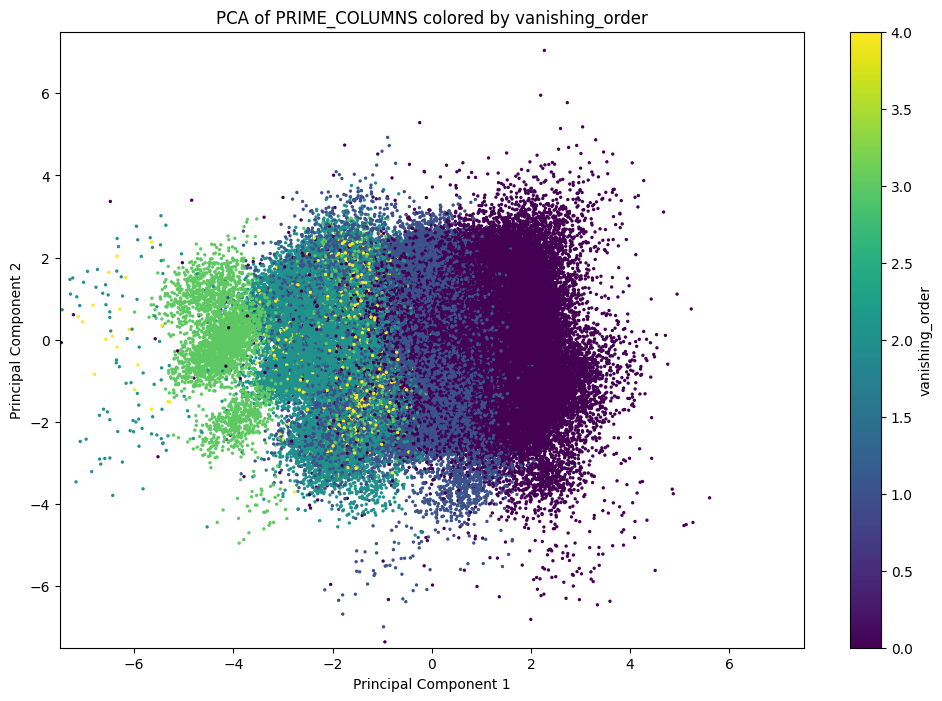

In [8]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=[12, 8])
scatter = ax.scatter(
    pca_df["PC1"], pca_df["PC2"], 
    c=pca_df["vanishing_order"], 
    cmap="viridis", 
    alpha=1,
    s=2
)

# Add colorbar and labels
fig.colorbar(scatter, label="vanishing_order")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("PCA of PRIME_COLUMNS colored by vanishing_order")
ax.set_xlim(-7.5, 7.5)  # chosen by inspection
ax.set_ylim(-7.5, 7.5)  # not particularly natural

#fig

In our paper, we include vanishing orders from $0$ to $3$. We include $4$ here, but that data is much sparser than the others.

The point is that these clusters appear to be pretty well-defined, even in only $2$ dimensions. This suggests that linear decision boundaries might suffice to distinguish between vanishing orders. Let's perform a LDA separation.

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


# Mask rows with vanishing_order between 0 and 4
mask = DF_norm["order_of_vanishing"].between(0, 4)
filtered = DF_norm[mask]

X = filtered[PRIME_COLUMNS].values
y = filtered["order_of_vanishing"].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=314159, stratify=y
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)

# Predictions
y_pred = lda.predict(X_test_scaled)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8704067775998703
              precision    recall  f1-score   support

           0       0.93      0.84      0.88     22259
           1       0.82      0.90      0.86     19484
           2       0.86      0.92      0.89      6682
           3       0.90      0.77      0.83       742
           4       0.00      0.00      0.00       172

    accuracy                           0.87     49339
   macro avg       0.70      0.69      0.69     49339
weighted avg       0.87      0.87      0.87     49339



Text(0.5, 1.0, 'Projection onto LDA principal axis')

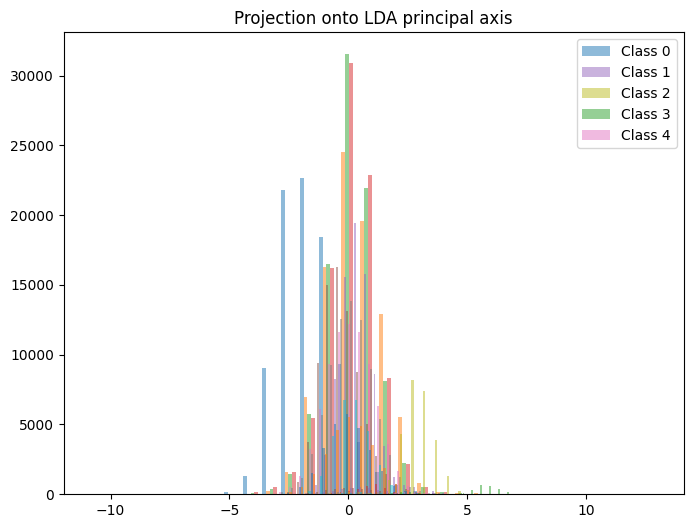

In [10]:
scores_train = lda.transform(X_train_scaled)
scores_test = lda.transform(X_test_scaled)


fig, ax = plt.subplots(figsize=(8, 6))
for lab, marker in zip(np.unique(y_train), ['o', 's', '^', 'x', '+']):
    ax.hist(scores_train[y_train==lab], bins=30, alpha=0.5,
            label=f"Class {lab}")
ax.legend()
ax.set_title("Projection onto LDA principal axis")

In [11]:
from sklearn.inspection import permutation_importance


r = permutation_importance(lda, X_test_scaled, y_test, n_repeats=50, random_state=314159)
perm_importances = pd.DataFrame({'feature': filtered[PRIME_COLUMNS].columns,
                                 'importance_mean': r.importances_mean,
                                 'importance_std': r.importances_std})
perm_importances.sort_values('importance_mean', ascending=False)

feature  importance_mean  importance_std
5        13         0.042678        0.000862
4        11         0.040870        0.000925
3         7         0.040661        0.000815
7        19         0.037700        0.000879
2         5         0.037221        0.000829
..      ...              ...             ...
110     607         0.000384        0.000293
146     853         0.000311        0.000282
153     887         0.000268        0.000240
165     983         0.000192        0.000247
159     941         0.000175        0.000270

[168 rows x 3 columns]

We have some weak suggestions that the smaller coefficients are more important than later coefficients, sure.

In [12]:
print("Explained variance ratio (per axis):", lda.explained_variance_ratio_)

Explained variance ratio (per axis): [9.7747040e-01 2.1081256e-02 1.0345095e-03 4.1377844e-04]


Text(0.5, 1.0, 'Scree plot of LDA discriminant directions')

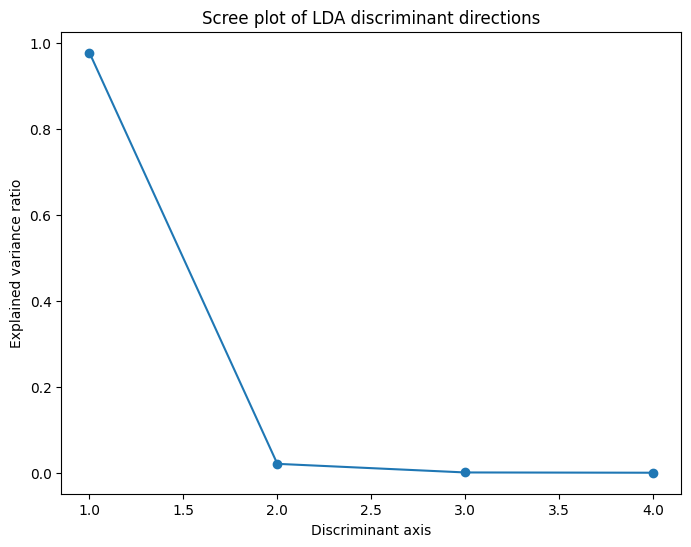

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(1, len(lda.explained_variance_ratio_)+1),
        lda.explained_variance_ratio_, 'o-')
ax.set_xlabel("Discriminant axis")
ax.set_ylabel("Explained variance ratio")
ax.set_title("Scree plot of LDA discriminant directions")

This suggests that the first axis has essentially all of the explanatory power.

Text(0.5, 1.0, 'Multiclass LDA Projection')

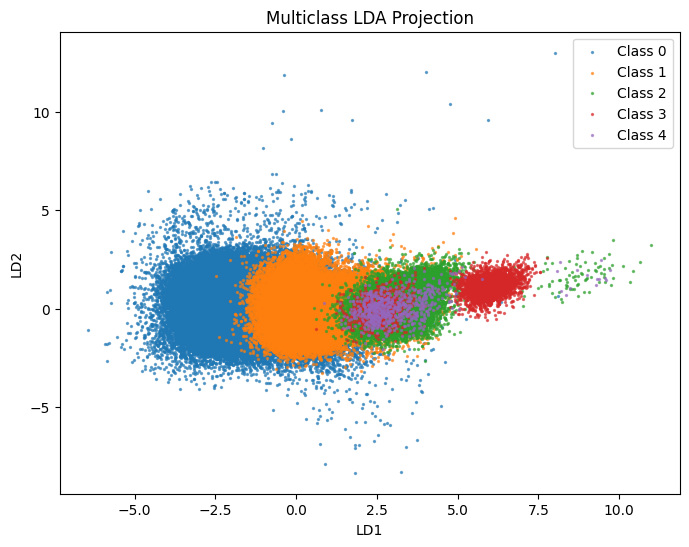

In [14]:
X_train_lda = lda.transform(X_train_scaled)
X_test_lda = lda.transform(X_test_scaled)

# Project onto the two most important discriminant axes
fig, ax = plt.subplots(figsize=(8, 6))
for lab in np.unique(y_train):
    ax.scatter(X_train_lda[y_train==lab, 0],
               X_train_lda[y_train==lab, 1],
               alpha=0.6, label=f"Class {lab}", s=2)
ax.set_xlabel("LD1")
ax.set_ylabel("LD2")
ax.legend()
ax.set_title("Multiclass LDA Projection")

Unsurprisingly, this is very reminiscent of the SVD/PCA analysis plot above.

In [15]:
centroids = pd.DataFrame({
    'class': np.unique(y_train),
    'LD1': [X_train_lda[y_train==lab,0].mean() for lab in np.unique(y_train)],
    'LD2': [X_train_lda[y_train==lab,1].mean() for lab in np.unique(y_train)]
})
print(centroids)

   class       LD1       LD2
0      0 -1.573073  0.156453
1      1  0.500681 -0.292475
2      2  3.118246  0.229223
3      3  5.239900  0.903363
4      4  3.093738  0.076376


Text(0.5, 1.0, 'LDA confusion matrix (test)')

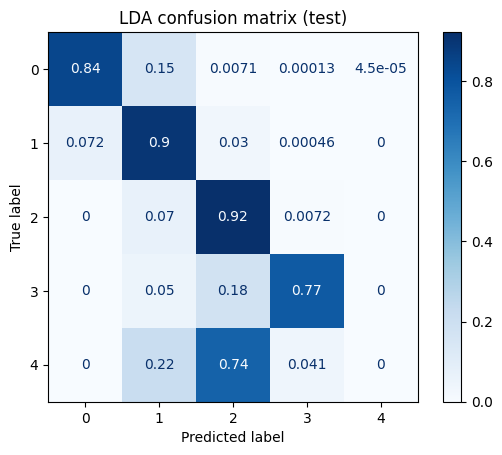

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = lda.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred, labels=lda.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lda.classes_)
disp.plot(cmap='Blues')
ax = disp.ax_
ax.set_title("LDA confusion matrix (test)")

This identifies orders $0$ to $3$ very well (and completely flails with order $4$, almost certainly due to poor data support).

In [17]:
# Within- and between-class scatter
overall_mean = X_train_scaled.mean(axis=0)
classes = np.unique(y_train)

S_W = np.zeros((X_train_scaled.shape[1], X_train_scaled.shape[1]))
S_B = np.zeros_like(S_W)

for c in classes:
    Xc = X_train_scaled[y_train==c]
    mean_c = Xc.mean(axis=0)
    S_W += np.cov(Xc, rowvar=False) * (Xc.shape[0]-1)
    n_c = Xc.shape[0]
    mean_diff = (mean_c - overall_mean).reshape(-1,1)
    S_B += n_c * (mean_diff @ mean_diff.T)

# Solve generalized eigenproblem
eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(S_W) @ S_B)

# Sort
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx].real
eigvecs = eigvecs[:,idx].real

print("Top eigenvalues (discriminative strength):", eigvals[:5])

Top eigenvalues (discriminative strength): [2.97874807e+00 6.42431948e-02 3.15256533e-03 1.26095142e-03
 2.28691727e-08]




## Out of Distribution Data ##

Sergei Gukov asked during the talk what happens on out-of-distribution data. Given nonsense, or perhaps misplaced data, what does the model say? Let's see!

Given any set of $168$ real numbers, we can pretend that they are the (normalized) coefficients $a_p$ for primes up to $1000$ of some $L$-function. (Actually, as long as these coefficients are between $-1$ and $1$, they **are** $\epsilon$-close to some $L$-function).

For example, suppose we choose random integers between $-5$ and $5$, $10$ times, and feed it to our model. What do we get?

In [18]:
# random data
import random

for idx in range(10):
    random_data = np.array([random.randint(-5, 5) for _ in range(168)])
    print(f"v_{idx} prediction: {lda.predict(random_data.reshape(1, -1))[0]}")

v_0 prediction: 3
v_1 prediction: 0
v_2 prediction: 1
v_3 prediction: 2
v_4 prediction: 0
v_5 prediction: 1
v_6 prediction: 0
v_7 prediction: 0
v_8 prediction: 2
v_9 prediction: 0


Let's organize this better.

In [19]:
def uniform_experiment(lower_bound, upper_bound=None, n_iter=10000):
    if upper_bound is None:
        if lower_bound < 0:
            upper_bound = -lower_bound
        else:
            upper_bound = 2 * lower_bound
    random_data = np.random.randint(lower_bound, high=upper_bound, size=(n_iter, 168))
    preds = lda.predict(random_data)
    print(f"After {n_iter} iterations of vectors with entries from {lower_bound} to {upper_bound}: avg predicted rank is {preds.mean()}")


for _ in range(10):
    uniform_experiment(-5, 5)

After 10000 iterations of vectors with entries from -5 to 5: avg predicted rank is 2.492
After 10000 iterations of vectors with entries from -5 to 5: avg predicted rank is 2.4833
After 10000 iterations of vectors with entries from -5 to 5: avg predicted rank is 2.4889
After 10000 iterations of vectors with entries from -5 to 5: avg predicted rank is 2.4902
After 10000 iterations of vectors with entries from -5 to 5: avg predicted rank is 2.4959
After 10000 iterations of vectors with entries from -5 to 5: avg predicted rank is 2.5008
After 10000 iterations of vectors with entries from -5 to 5: avg predicted rank is 2.4915
After 10000 iterations of vectors with entries from -5 to 5: avg predicted rank is 2.5016
After 10000 iterations of vectors with entries from -5 to 5: avg predicted rank is 2.4798
After 10000 iterations of vectors with entries from -5 to 5: avg predicted rank is 2.4788


Is it surprising that it's consistent instead of random? I don't know. Let's do a couple of other ranges.

In [20]:
for _ in range(3):
    uniform_experiment(4, 6)
for _ in range(3):
    uniform_experiment(0, 10)
for _ in range(3):
    uniform_experiment(-1, 1)
for _ in range(3):
    uniform_experiment(-10, 0)
for _ in range(3):
    uniform_experiment(-6, -4)

After 10000 iterations of vectors with entries from 4 to 6: avg predicted rank is 0.0
After 10000 iterations of vectors with entries from 4 to 6: avg predicted rank is 0.0
After 10000 iterations of vectors with entries from 4 to 6: avg predicted rank is 0.0
After 10000 iterations of vectors with entries from 0 to 10: avg predicted rank is 0.0
After 10000 iterations of vectors with entries from 0 to 10: avg predicted rank is 0.0
After 10000 iterations of vectors with entries from 0 to 10: avg predicted rank is 0.0
After 10000 iterations of vectors with entries from -1 to 1: avg predicted rank is 2.9779
After 10000 iterations of vectors with entries from -1 to 1: avg predicted rank is 2.9795
After 10000 iterations of vectors with entries from -1 to 1: avg predicted rank is 2.9754
After 10000 iterations of vectors with entries from -10 to 0: avg predicted rank is 3.0
After 10000 iterations of vectors with entries from -10 to 0: avg predicted rank is 3.0
After 10000 iterations of vectors w

How about from normal distributions?

In [21]:
def gaussian_experiment(center=0, stddev=1, n_iter=10000):
    random_data = np.random.normal(loc=center, scale=stddev, size=(n_iter, 168))
    preds = lda.predict(random_data)
    print(f"After {n_iter} iterations of vectors Gaussian({center}, {stddev}) entries: avg predicted rank is {preds.mean()}")


for _ in range(10):
    gaussian_experiment()

After 10000 iterations of vectors Gaussian(0, 1) entries: avg predicted rank is 0.6823
After 10000 iterations of vectors Gaussian(0, 1) entries: avg predicted rank is 0.6896
After 10000 iterations of vectors Gaussian(0, 1) entries: avg predicted rank is 0.6743
After 10000 iterations of vectors Gaussian(0, 1) entries: avg predicted rank is 0.6889
After 10000 iterations of vectors Gaussian(0, 1) entries: avg predicted rank is 0.6911
After 10000 iterations of vectors Gaussian(0, 1) entries: avg predicted rank is 0.6879
After 10000 iterations of vectors Gaussian(0, 1) entries: avg predicted rank is 0.6844
After 10000 iterations of vectors Gaussian(0, 1) entries: avg predicted rank is 0.6937
After 10000 iterations of vectors Gaussian(0, 1) entries: avg predicted rank is 0.6909
After 10000 iterations of vectors Gaussian(0, 1) entries: avg predicted rank is 0.6833


In [22]:
for _ in range(3):
    gaussian_experiment(0, 2)
for _ in range(3):
    gaussian_experiment(-1, 2)
for _ in range(3):
    gaussian_experiment(-1)
for _ in range(3):
    gaussian_experiment(1)
for _ in range(3):
    gaussian_experiment(1, 2)

After 10000 iterations of vectors Gaussian(0, 2) entries: avg predicted rank is 0.8428
After 10000 iterations of vectors Gaussian(0, 2) entries: avg predicted rank is 0.833
After 10000 iterations of vectors Gaussian(0, 2) entries: avg predicted rank is 0.8387
After 10000 iterations of vectors Gaussian(-1, 2) entries: avg predicted rank is 2.9974
After 10000 iterations of vectors Gaussian(-1, 2) entries: avg predicted rank is 2.9983
After 10000 iterations of vectors Gaussian(-1, 2) entries: avg predicted rank is 2.9985
After 10000 iterations of vectors Gaussian(-1, 1) entries: avg predicted rank is 3.0
After 10000 iterations of vectors Gaussian(-1, 1) entries: avg predicted rank is 3.0
After 10000 iterations of vectors Gaussian(-1, 1) entries: avg predicted rank is 3.0
After 10000 iterations of vectors Gaussian(1, 1) entries: avg predicted rank is 0.0
After 10000 iterations of vectors Gaussian(1, 1) entries: avg predicted rank is 0.0
After 10000 iterations of vectors Gaussian(1, 1) entr

I notice that there is a very strong relationship between having lots of large magnitude, negative coefficients and having large predicted analytic rank. This is very consistent with BSD-type conjectures, which include the conjecture that

$$ \lim_{X \to \infty} \frac{1}{\log X} \sum_{p \leq X} \frac{a_E(p) \log p}{p} = - r + \frac{1}{2}. $$

Thus we should expect a preponderance of early negative coefficients to lead to a larger rank. The LDA has picked up on this broad pattern.

## Mestre Nagao ##

Let's look more closely at how much of the Mestre Nagao sums have been incorporated into this model. We compute the sums

$$ \sum_{p \leq X} \frac{a_p \log p}{p} $$

and compare to the projections onto the principal LDA axis.

In [23]:
primes = [p for p in range(1000) if is_prime(p)]
primes = np.array(primes)


def mestre_nagao(X):
    logs = np.log(primes)
    return (X * logs / primes).sum(axis=1)


C_train = mestre_nagao(X_train)
C_test = mestre_nagao(X_test)

Pearson correlations between C and LD axes (train):
  LD1: r = -0.9589
  LD2: r = -0.2654
  LD3: r = -0.0488
  LD4: r = 0.0159


Text(0.5, 1.0, 'Mestre-Nagao vs LD1')

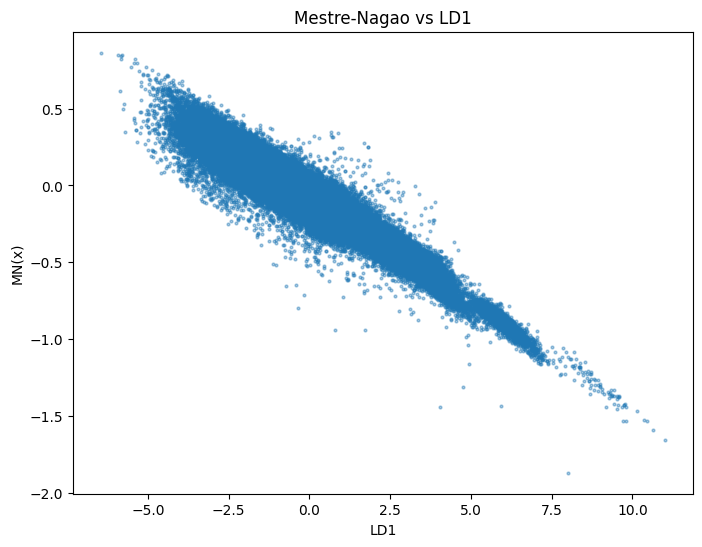

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.utils import resample


X_train_lda = lda.transform(scaler.transform(X_train))  # make sure we have same standardization
ld_cols = [f"LD{i+1}" for i in range(X_train_lda.shape[1])]
lda_df = pd.DataFrame(X_train_lda, columns=ld_cols)
corrs = [np.corrcoef(C_train, X_train_lda[:,k])[0,1] for k in range(X_train_lda.shape[1])]
print("Pearson correlations between C and LD axes (train):")
for k,rval in enumerate(corrs):
    print(f"  LD{k+1}: r = {rval:.4f}")

# Quick scatter of C vs LD1
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(X_train_lda[:,0], C_train, alpha=0.4, s=4)
ax.set_xlabel("LD1")
ax.set_ylabel("MN(x)")
ax.set_title("Mestre-Nagao vs LD1")

Will you look at that. The Mestre-Nagao sums correlate **really obviously** with the first discriminant axis.

For each (normalized) $L$-function, this plot compares the projection of the data vector associated to that $L$-function on the principal LDA axis against the associated (normalized) Mestre-Nagao sum. And the point seems to be that they are strongly linear correlated!

In [25]:
lr = LinearRegression()
lr.fit(C_train.reshape(-1,1), X_train_lda[:,0])  # just use principal axis
pred = lr.predict(C_train.reshape(-1,1))
r2 = r2_score(X_train_lda[:,0], pred)
print(f"R^2 of regressing LD1 on C (train): {r2:.4f}")

# Let's also look at what happens on the validation data
X_test_lda = lda.transform(scaler.transform(X_test))
pred_test = lr.predict(C_test.reshape(-1,1))
r2_test = r2_score(X_test_lda[:,0], pred_test)
print(f"R^2 on test set: {r2_test:.4f}")

R^2 of regressing LD1 on C (train): 0.9194
R^2 on test set: 0.9201


As a small experiment, what if we add in Mestre-Nagao sums and retrain our predictor. Do we do better?

In [26]:
sc2 = StandardScaler()
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

C_train_scaled = (C_train - C_train.mean()) / (C_train.std(ddof=0) + 1e-12)
C_test_scaled  = (C_test - C_train.mean()) / (C_train.std(ddof=0) + 1e-12)

X_train_aug = np.hstack([X_train_scaled, C_train_scaled.reshape(-1,1)])
X_test_aug = np.hstack([X_test_scaled, C_test_scaled.reshape(-1,1)])

lda_aug = LinearDiscriminantAnalysis()
lda_aug.fit(X_train_aug, y_train)

print("Original LDA train acc:", lda.score(X_train_scaled, y_train), "test acc:", lda.score(X_test_scaled, y_test))
print("Augmented LDA train acc:", lda_aug.score(X_train_aug, y_train), "test acc:", lda_aug.score(X_test_aug, y_test))

print("Explained variance ratio (original):", lda.explained_variance_ratio_)
print("Explained variance ratio (augmented):", lda_aug.explained_variance_ratio_)


Original LDA train acc: 0.8684495880499001 test acc: 0.8704067775998703
Augmented LDA train acc: 0.8684597221236965 test acc: 0.8704067775998703
Explained variance ratio (original): [9.7747040e-01 2.1081256e-02 1.0345095e-03 4.1377844e-04]
Explained variance ratio (augmented): [9.77470147e-01 2.10814738e-02 1.03461600e-03 4.13763677e-04]


There is no additional explanatory power from incorporating Mestre-Nagao sums! That's interesting.